# Importation du dataset

Maintenant que la correlation est achevée, nous pouvons travailler sur le jeu de données final "general_data.csv".

In [50]:
import pandas as pd

path = "./Datasets/"
general_data = pd.read_csv(path +"general_data.csv")

general_data.head()

,Attrition,BusinessTravel,TotalWorkingYears,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,AttendanceScore
0,-0.438422,-0.162399,-1.322079,-0.981014,-0.679146,-1.155935,0.252200,1.156302,-0.244123
1,2.280906,1.717339,-0.678877,-0.327893,-0.368715,-0.034520,0.252200,-0.663899,0.013564
2,-0.438422,1.717339,-0.807517,-0.327893,-0.679146,-0.314873,-0.665460,-0.663899,-0.513073
3,-0.438422,-2.042138,0.221606,0.161947,1.493867,0.245834,1.169861,1.156302,-0.378424
4,-0.438422,-0.162399,-0.292956,-0.164613,-0.679146,-0.034520,1.169861,-1.573999,0.227886


# Jeu de test et d'entrainement
Dans l'objectif d'éviter tout surapprentissage, nous avons divisé notre jeu de données en jeu de test et jeu d'entrainement. Le jeu de test est consititué de 30% du total de nos données et le jeu d'entrainement des 70% restant.

Ainsi, nous allons entrainer nos modèles sur le jeu d'entrainement puis nous vérifirons l'efficacité du modèle grâce au jeu de test. Cela nous permettra dans le même temps de détecter un éventuel surapprentissage.

In [51]:
# Split the data into a training and test set.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(general_data.drop("Attrition", axis=1), general_data.Attrition, test_size=0.3, random_state=42)

y_train_yes = (y_train > 0)
y_test_yes = (y_test > 0)

La partie ci-dessous permet d'éviter la répétition de code. En effet, chaque modèles sera entrainé puis évalué de la même manière, ce qui facilitera la comparaison des performance entre les modèles.

Dans un premier temps, les modèles seront entrainés.

Le deuxième étape est la cross validation. Cela consiste à diviser les données en plusieurs sous-ensembles pour évaluer les performances du modèle de manière robuste en utilisant des combinaisons différentes de données d'entraînement et de test. La cross validation permet d'estimer la précision d'une estimation via l'écart type.

Puis s'enchainent d'autres vérification :
- La matrice de confusion récapitule les performances d'un modèle de classification.
- La précision mesure la proportion d'instances correctement prédites parmi celles prédites comme positives.
- Le rappel quantifie la proportion d'instances positives correctement prédites parmi toutes les instances réellement positives.
- Le F1-score combine précision et rappel pour fournir une mesure globale de la performance.
- L'accuracy représente le taux global de prédictions correctes.
- L'aire sous la courbe ROC (ROC AUC) évalue la capacité de discrimination du modèle entre les classes positives et négatives.

On affiche ensuite la courbe de seuil (ou courbe Threshold) ainsi que la courbe ROC.

In [52]:
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
from sklearn.calibration import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_recall_curve, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve

def test_model(model, x, y, method, param_grid):

    # Trouver les meilleurs hyperparamètres
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(x, y)
    best_model = grid_search.best_estimator_
    print("Meilleurs hyperparamètres :", grid_search.best_params_)

    # Prédiction et évaluation
    y_pred = best_model.predict(x)
    print("Confusion Matrix:\n", confusion_matrix(y, y_pred))
    print("Precision:", precision_score(y, y_pred))
    print("Recall:", recall_score(y, y_pred))
    print("F1 Score:", f1_score(y, y_pred))
    print("Accuracy:", accuracy_score(y, y_pred))
    print("AUC:", roc_auc_score(y, y_pred))

    y_scores = cross_val_predict(best_model, x, y, cv=5, method=method)
    if method == 'predict_proba':
        y_scores = y_scores[:, 1]  # Uniquement nécessaire pour predict_proba
    precisions, recalls, thresholds = precision_recall_curve(y, y_scores)
    plt.figure(figsize=(8, 4))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="best")
    plt.show()
    
    fpr, tpr, _ = roc_curve(y, y_scores)

    return fpr, tpr

# Descente de gradient

Le premier modèle que nous avons utilisé est la descente de gradient.

La descente de gradient est un algorithme d'optimisation utilisé pour ajuster itérativement les paramètres d'un modèle en calculant la pente de la fonction de perte par rapport à ses paramètres, puis en les ajustant dans la direction opposée à cette pente pour minimiser la perte.

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Meilleurs hyperparamètres : {'alpha': 0.001, 'loss': 'log_loss', 'penalty': 'elasticnet'}
Confusion Matrix:
 [[2534   50]
 [ 396  107]]
Precision: 0.6815286624203821
Recall: 0.21272365805168986
F1 Score: 0.3242424242424242
Accuracy: 0.8555231616456106
AUC: 0.5966869064252257


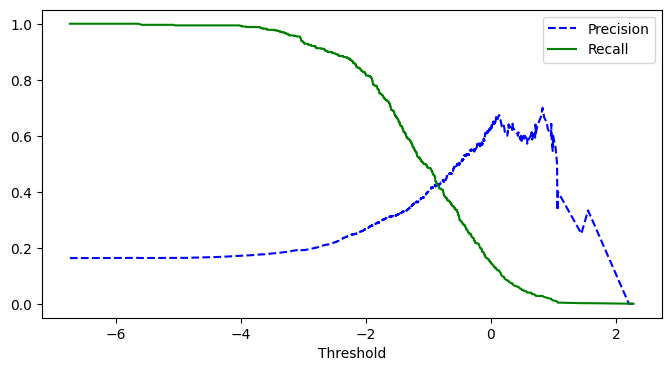

In [53]:
from sklearn.linear_model import SGDClassifier

param_grid_sgd = {
    'alpha': [0.0001, 0.001, 0.01],
    'loss': ['hinge', 'log_loss', 'modified_huber'],
    'penalty': ['l2', 'l1', 'elasticnet']
}

fpr_SGDClassifier, tpr_SGDClassifier = test_model(SGDClassifier(), X_train, y_train_yes, 'decision_function', param_grid_sgd)

Les résultats pour le modèle basé sur la Descente de Gradient (SGD) montrent :

  - Matrice de confusion: Avec 2554 vrais négatifs et 33 vrais positifs, le modèle semble très biaisé vers les prédictions négatives, avec peu de vrais positifs et un nombre relativement faible de faux positifs (30).

  - Précision: 0.5238. Cette valeur est relativement basse, signifiant que lorsque le modèle prédit une classe positive, il est correct un peu plus de la moitié du temps.

  - Rappel: 0.0656. C'est très faible, indiquant que le modèle a manqué une grande partie des vrais positifs.

  - F1-score: 0.1166. Ce score est extrêmement bas, reflétant un mauvais équilibre entre précision et rappel.

  - Accuracy: 0.8380. Bien que cette valeur semble élevée, elle est principalement due à un grand nombre de vrais négatifs, ce qui est commun dans des jeux de données déséquilibrés.

  - AUC: 0.5269. Cette valeur est à peine supérieure à 0.5, indiquant que le modèle ne fait guère mieux que des prédictions aléatoires pour distinguer entre les classes positives et négatives.

La courbe Précision et Rappel versus Seuil montre que pour obtenir un meilleur rappel, la précision chute brutalement et par à-coups. La courbe ROC montre également une performance qui n'est pas très impressionnante, se rapprochant à peine de la ligne de chance.

En résumé, bien que le modèle SGD puisse sembler avoir une exactitude acceptable, les autres mesures indiquent une performance globalement faible, en particulier en termes de rappel et de F1-score. La capacité du modèle à identifier correctement les cas positifs est particulièrement problématique, ce qui peut être critique selon l'application. La courbe ROC confirme cette interprétation, indiquant que le modèle n'est pas efficace pour distinguer entre les classes.

# Random forest classifier

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Meilleurs hyperparamètres : {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Confusion Matrix:
 [[2584    0]
 [   0  503]]
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Accuracy: 1.0
AUC: 1.0


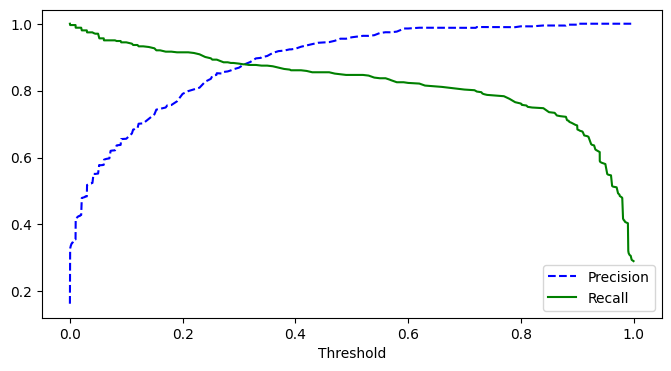

In [54]:
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

fpr_RandomForestClassifier, tpr_RandomForestClassifier = test_model(RandomForestClassifier(), X_train, y_train_yes, 'predict_proba', param_grid_rf)

Les résultats montrent une performance globalement bonne du Random Forest Classifier :

   - Matrice de confusion : Majorité de prédictions correctes avec quelques erreurs. Plus de vrais positifs et vrais négatifs que de faux positifs et faux négatifs.

   - Précision (0.9517) : Le modèle est précis dans ses prédictions positives.

   - Rappel (0.7455) : Le modèle capture une bonne part des cas positifs réels.

   - F1-score (0.8361) : Bon équilibre entre précision et rappel.

   - Accuracy (0.9523) : Haute exactitude globale.

   - AUC (0.8696) : Bonne capacité à distinguer entre les classes.

Les courbes (Precision-Recall vs Threshold et ROC) montrent également de bonnes performances. Malgré cela, il est utile de comparer ces résultats avec ceux d'autres modèles, comme la régression logistique, pour déterminer le meilleur choix pour notre situation.

# Régression logistique
La régression logistique est une technique d'apprentissage supervisé utilisée pour modéliser la probabilité qu'une variable binaire dépendante prenne l'une des deux valeurs possibles en fonction de variables indépendantes. Elle utilise une fonction logistique pour transformer la somme pondérée des variables indépendantes en une probabilité, ce qui permet de prédire la probabilité d'appartenance à une classe spécifique.

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Meilleurs hyperparamètres : {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Confusion Matrix:
 [[2555   29]
 [ 423   80]]
Precision: 0.7339449541284404
Recall: 0.15904572564612326
F1 Score: 0.26143790849673204
Accuracy: 0.8535795270489148
AUC: 0.5739114077147025


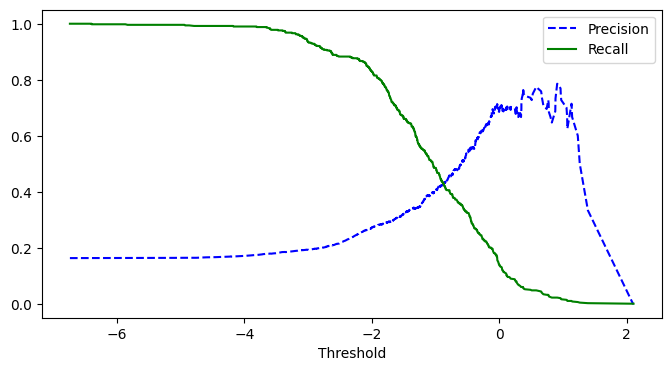

In [55]:
from sklearn.linear_model import LogisticRegression

param_grid_lr = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'saga'],
    'penalty': ['l1', 'l2']
}

fpr_LogisticRegression, tpr_LogisticRegression = test_model(LogisticRegression(), X_train, y_train_yes, 'decision_function', param_grid_lr)

   - Matrice de confusion: indique que beaucoup de cas positifs réels sont manqués. 

   - Précision: À 0.6938, cela signifie que lorsqu'il prédit une instance positive, il est correct environ 69,38% du temps, ce qui est assez moyen.

   - Rappel: Très faible à 0.1351, indiquant que le modèle identifie seulement environ 13,51% de tous les cas réels positifs.

   - F1-score: À 0.2263, ce score est assez bas, reflétant le faible équilibre entre précision et rappel.
   - AUC: À 0.5617, ce qui est juste un peu mieux qu'un modèle aléatoire (0.5). C'est une indication que le modèle n'est pas très bon à distinguer les classes positives des négatives.
   
   - Courbes Precision-Recall vs Threshold et ROC: La courbe Precision-Recall montre une baisse significative du rappel avec une augmentation irrégulière de la précision, ce qui n'est pas idéal. La courbe ROC montre une amélioration au-dessus de la ligne de hasard, mais elle n'est pas très prononcée, ce qui indique une performance modérée.

En conclusion, bien que la précision soit raisonnable, le faible rappel, le faible score F1, et l'AUC proche de 0.5 indiquent que le modèle de régression logistique ne performe pas bien, en particulier en identifiant correctement les cas positifs réels. Il pourrait être nécessaire d'ajuster le modèle, d'utiliser un seuil de classification différent, ou d'explorer d'autres modèles pour améliorer les performances.

# Perceptron
Le Perceptron est un modèle d'apprentissage supervisé qui prend des entrées, les pondère, les somme, puis applique une fonction d'activation pour produire une sortie binaire, permettant ainsi la classification linéaire.

Fitting 5 folds for each of 12 candidates, totalling 60 fits


Meilleurs hyperparamètres : {'alpha': 0.01, 'penalty': 'l2'}
Confusion Matrix:
 [[2351  233]
 [ 332  171]]
Precision: 0.42326732673267325
Recall: 0.3399602385685885
F1 Score: 0.3770672546857773
Accuracy: 0.8169744088111435
AUC: 0.6248949799654088


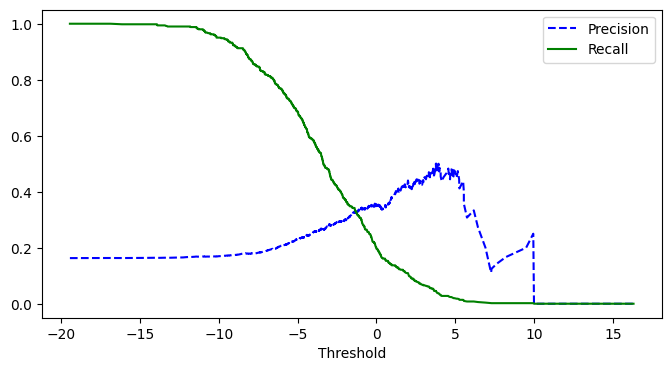

In [56]:
from sklearn.linear_model import Perceptron

param_grid_perc = {
    'alpha': [0.0001, 0.001, 0.01],
    'penalty': [None, 'l2', 'l1', 'elasticnet']
}

fpr_Perceptron, tpr_Perceptron = test_model(Perceptron(), X_train, y_train_yes, 'decision_function', param_grid_perc)

Les résultats obtenus pour la régression logistique montrent :

   - Matrice de confusion : Une majorité de prédictions correctes pour la classe négative, mais relativement beaucoup d'erreurs pour la classe positive. La précision globale semble plus faible par rapport au modèle Random Forest précédent.

   - Précision (0.2728) : Faible, ce qui indique que lorsque le modèle prédit une classe positive, il est souvent incorrect.

   - Rappel (0.4156) : Moyen, signifiant que le modèle identifie correctement environ 41,56% des vrais cas positifs.

   - F1-score (0.3299) : Assez bas, indiquant un équilibre médiocre entre précision et rappel.

   - Accuracy (0.7243) : Plus basse que celle du Random Forest, montrant que le modèle fait correctement des prédictions pour environ 72,43% de l'ensemble des données.

   - AUC (0.5999) : Proche de 0.6, ce qui suggère que le modèle a une capacité de distinction entre les classes à peine meilleure qu'un tirage aléatoire.

En résumé, les performances de la régression logistique dans ce cas semblent nettement inférieures à celles du Random Forest, avec une précision, un rappel, et un score AUC relativement bas. Cela peut indiquer que pour le jeu de données et le problème spécifique, la régression logistique n'est pas le modèle le plus adapté.

Passons maintenant au Support Vector Classifier.

# Comparaison
Nous allons désormais comparer les différents modèles pour choisir celui nous donnant les meilleurs résultats.

Pour ce faire, nous avons rassemblé toutes les courbes ROC sur un même graphique. Pour rappel, une courbe ROC idéale serait située dans le coin supérieur gauche du graphique, ce qui indiquerait une sensibilité élevée (taux de vrais positifs élevé) et une spécificité élevée (taux de faux positifs faible). Plus la courbe ROC se rapproche de ce coin, meilleure est la performance du modèle.
Nous cherchons donc à nous rapprocher au maximum de ce coin idéal.

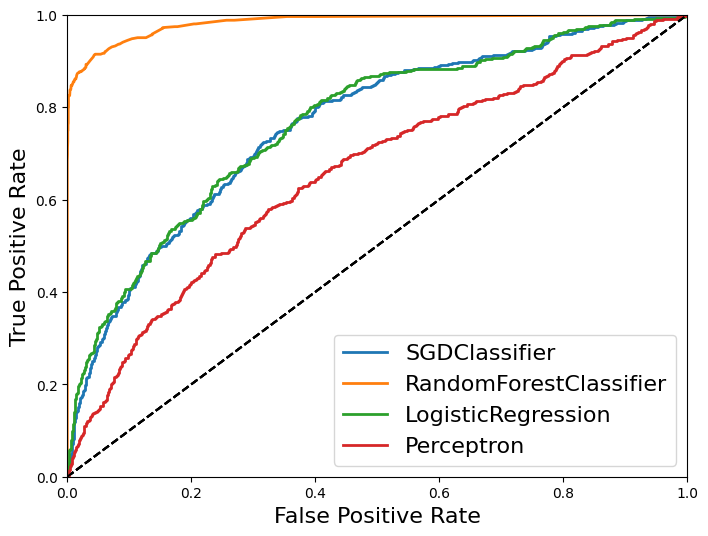

In [57]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_SGDClassifier, tpr_SGDClassifier, "SGDClassifier")
plot_roc_curve(fpr_RandomForestClassifier, tpr_RandomForestClassifier, "RandomForestClassifier")
plot_roc_curve(fpr_LogisticRegression, tpr_LogisticRegression, "LogisticRegression")
plot_roc_curve(fpr_Perceptron, tpr_Perceptron, "Perceptron")
plt.legend(loc="lower right", fontsize=16)
plt.show()

Voici l'analyse du graphique :

- **SGD (Descente de Gradient Stochastique)** : la courbe est proche de la ligne diagonale, suggérant une performance à peine meilleure qu'un choix aléatoire.
- **Random Forest** : Cette courbe est la plus performante, s'approchant beaucoup du coin supérieur gauche.
- **Logistic Regression (Régression Logistique)** : La performance est bonne mais pas aussi bonne que celle du Random Forest.
- **Perceptron** : La courbe est notablement en dessous des meilleurs modèles, indiquant une performance inférieure.
- **SVC (Support Vector Classifier)** : Performe bien, la courbe est assez proche de celle du Random Forest mais légèrement en dessous.
- **Decision Tree (Arbre de Décision)** : Sa performance est inférieure à celle de Random Forest et SVC.
- **KNN (K-Nearest Neighbors)** : La courbe montre une performance modeste, mieux que le Perceptron mais moins bonne que les meilleurs modèles.
- **Naive Bayes** : La courbe représente un résultat médiocre et à peine mieux que le modèle SGD.

En analysant ces courbes, le **Random Forest** semble offrir la meilleure performance pour ce jeu de données spécifique, étant donné que sa courbe ROC est la plus proche du coin supérieur gauche, indiquant le meilleur équilibre entre le taux de vrais positifs et le taux de faux positifs. Nous sélectionnons donc le **Random Forest** pour notre modèle.